# Import

In [112]:
import matplotlib.pyplot as plt
import numpy as np

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit.dagcircuit.dagcircuit import DAGCircuit, DAGOpNode


from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

# Parameters

In [2]:
def pytket(qc: QuantumCircuit, backend):
    tk_backend = IBMQBackend(backend.name, group='uw-madison')
    tk_qc = qiskit_to_tk(qc)
    tk_backend.default_compilation_pass(2).apply(tk_qc)
    tqc = tk_to_qiskit(tk_qc)
    return tqc

def qiskit_opt_0(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=0)

def qiskit_opt_3(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3)

def qiskit_opt_3_sabre(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3, layout_method='sabre', routing_method='sabre')

In [3]:
min_qubits, max_qubits = 4, 14
algorithms = { 'Bernstein Vazirani': bv, 'QFT': qft }
techniques = { 
    'PyTket': pytket,
    'Qiskit Opt 0': qiskit_opt_0, 
    'Qiskit Opt 3': qiskit_opt_3, 
    'Qiskit Opt 3 Sabre': qiskit_opt_3_sabre 
}

In [4]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_guadalupe")

In [5]:
# from qiskit.providers.fake_provider import FakeOslo
# fake_backend = FakeOslo()
# fake_backend.name = "ibm_oslo"

In [7]:
qcs = []
for al_name, al in algorithms.items():
    for n in range(min_qubits, max_qubits+1):
        qc = al.test(n)
        qcs.append(qc)

# Create Transpiled Circuits

In [ ]:
tqcs = []

for qc in qcs:
    for t_name, t in techniques.items():
        tqc = t(qc, backend)
        tqcs.append(tqc)

In [6]:
# qcs = []
# tqcs = []

# for al_name, al in algorithms.items():
#     for n in range(min_qubits, max_qubits+1):
#         qc = al.test(n)
#         qcs.append(qc)
#         for t_name, t in techniques.items():
#             tqc = t(qc, backend)
#             tqcs.append(tqc)

In [94]:
len(tqcs)

32

In [153]:
tqc = tqcs[20]

In [154]:
# tqc.draw('mpl')

In [155]:
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(tqc)

In [156]:
props = backend.properties()

In [163]:
for tqc in tqcs:
    dag = circuit_to_dag(tqc)
    total_time = 0
    for s in dag.layers():
        graph: DAGCircuit = s['graph']
        partition = s['partition']
        gate: DAGOpNode
        max_gate_time_in_layer = 0
        for gate in graph.gate_nodes():
            q_index = [qarg.index for qarg in gate.qargs]
            g_time = props.gate_length(gate.name, q_index)
            if g_time > max_gate_time_in_layer:
                max_gate_time_in_layer = g_time
        total_time += max_gate_time_in_layer
    print(total_time)

C:\Users\thspr\AppData\Local\Temp\ipykernel_16288\3196988739.py:10: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index = [qarg.index for qarg in gate.qargs]


9.493333333333332e-07
2.9155555555555553e-06
9.493333333333332e-07
1.0382222222222223e-06
1.898666666666666e-06
4.003555555555554e-06
2.3537777777777774e-06
1.7422222222222218e-06
3.0826666666666663e-06
3.413333333333333e-06
2.7946666666666663e-06
3.0364444444444442e-06
4.807111111111111e-06
5.887999999999999e-06
3.2497777777777774e-06
2.496e-06
4.849777777777777e-06
1.1342222222222219e-05
7.978666666666662e-06
7.982222222222222e-06
1.0122666666666667e-05
2.0448e-05
1.142044444444444e-05
1.1427555555555553e-05
1.626666666666666e-05
3.0115555555555558e-05
1.9911111111111112e-05
1.944177777777778e-05
2.499555555555555e-05
3.43608888888889e-05
2.7619555555555553e-05
2.774755555555555e-05


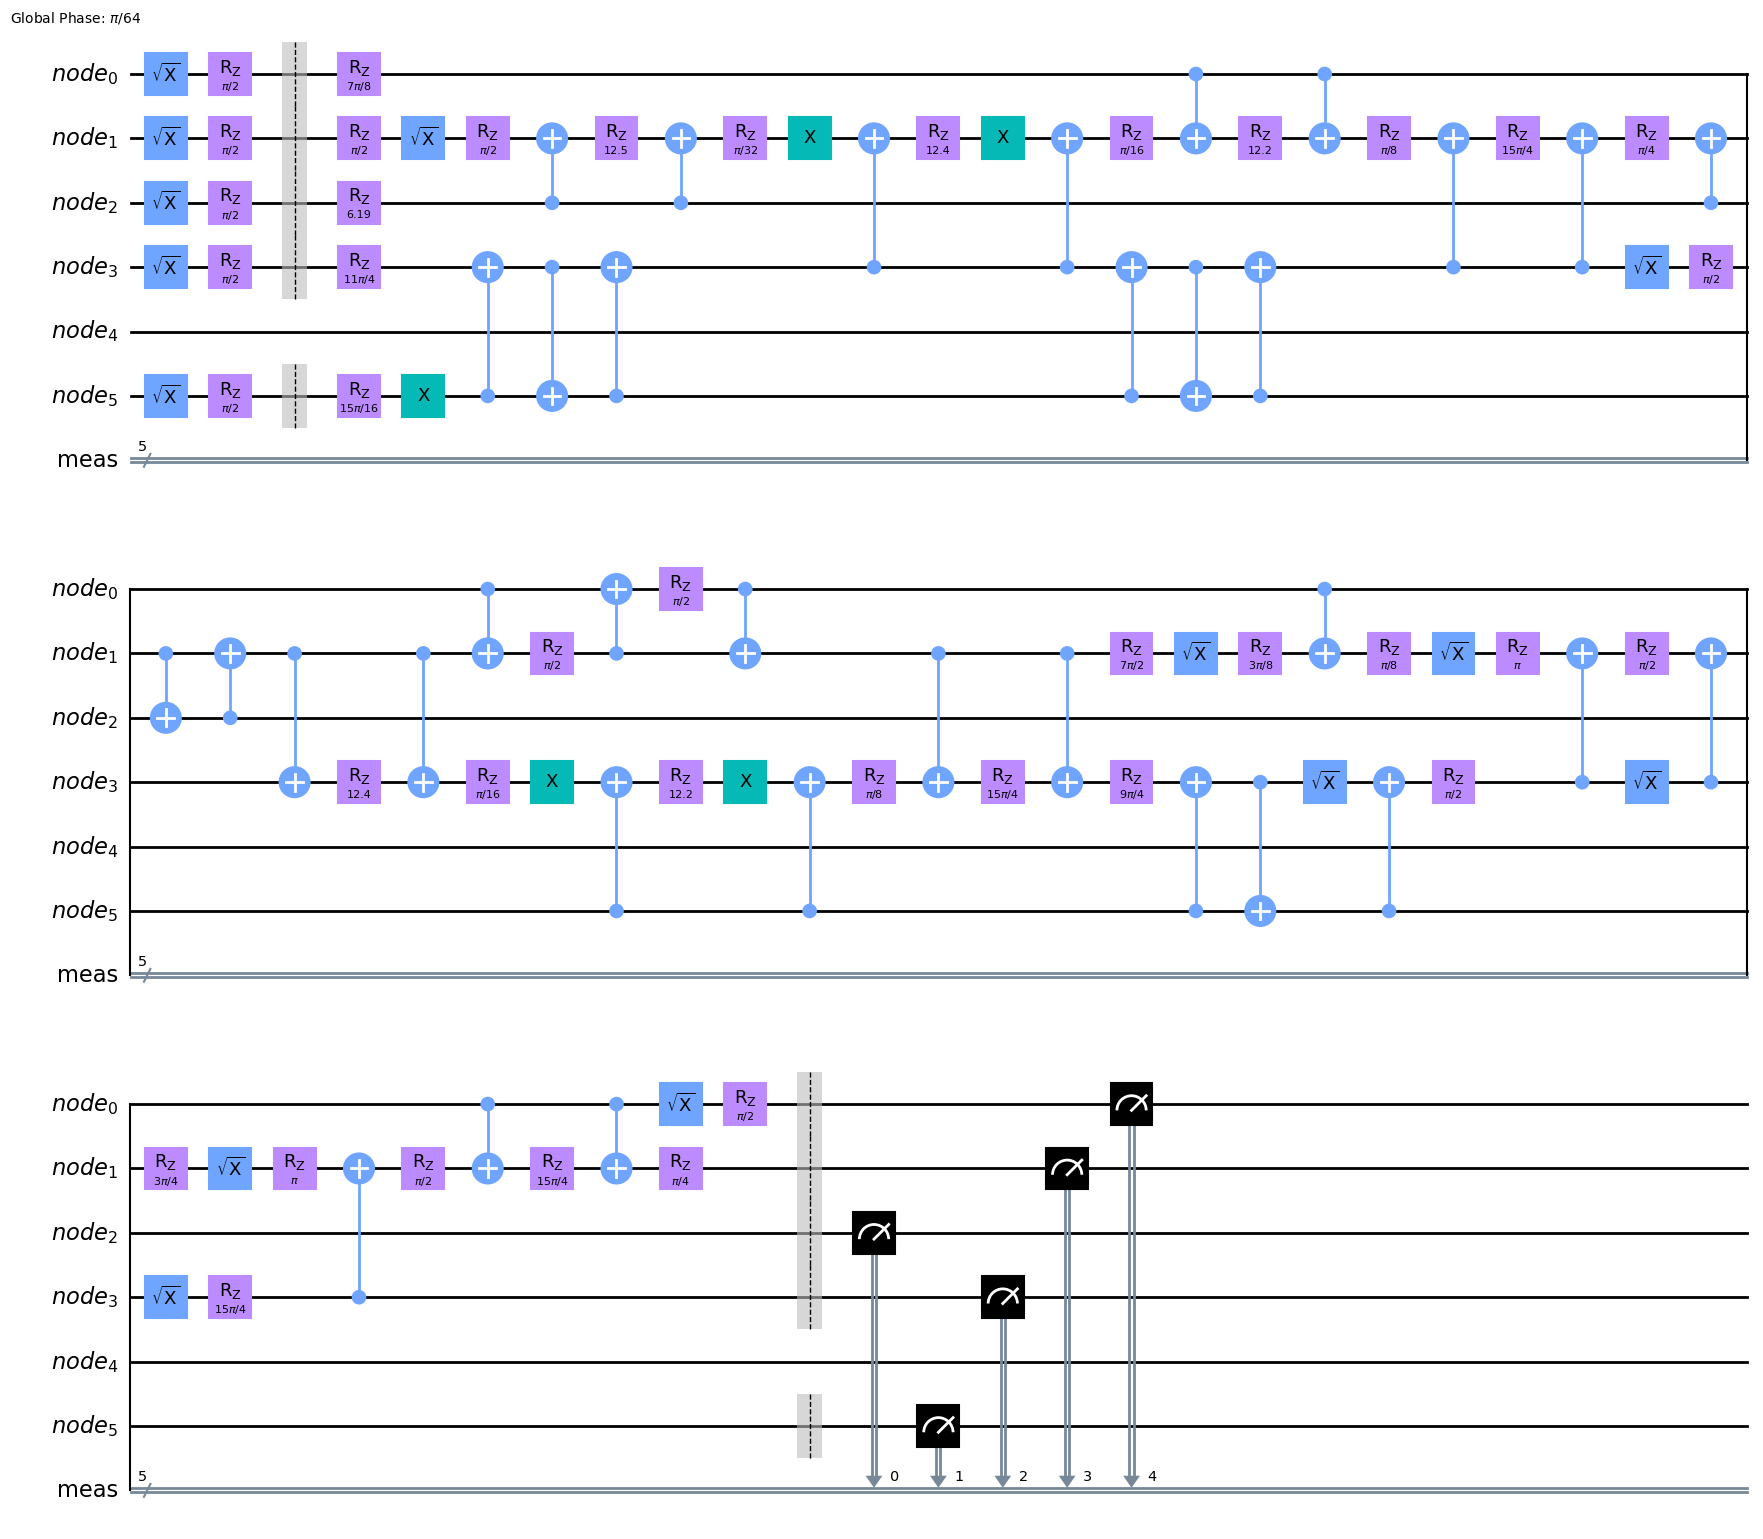

In [ ]:
tqc.draw('mpl')

In [54]:
backend.properties().gate_error('sx', 0)

0.00017096600068825917

In [117]:
backend.properties().gate_error('cx', (0, 1))

0.0061404845222989

In [62]:
props.gates[0]

In [ ]:
props.gate_length

In [53]:
props.gate_error('sx', 0)

0.00017096600068825917

# Simulate QCs

In [8]:
def simulate_classically(qc_list):
    aer_sim = Aer.get_backend('aer_simulator')
    tqc_list = transpile(qc_list, aer_sim)
    job_sim = aer_sim.run(tqc_list, shots=1000)
    results = job_sim.result()
    return results

In [9]:
sim_res_counts = simulate_classically(qcs).get_counts()
display(sim_res_counts)

[{'111': 1000},
 {'1111': 1000},
 {'11111': 1000},
 {'111111': 1000},
 {'1111111': 1000},
 {'11111111': 1000},
 {'111111111': 1000},
 {'1111111111': 1000},
 {'11111111111': 1000},
 {'111111111111': 1000},
 {'1111111111111': 1000},
 {'0000': 1000},
 {'00000': 1000},
 {'000000': 1000},
 {'0000000': 1000},
 {'00000000': 1000},
 {'000000000': 1000},
 {'0000000000': 1000},
 {'00000000000': 1000},
 {'000000000000': 1000},
 {'0000000000000': 1000},
 {'00000000000000': 1000}]

# Run on IBM QC

In [ ]:
# job = backend.run(tqcs, shots=1000)
# job = fake_backend.run(tqcs, shots=1000)

In [10]:
job = provider.backend.jobs()[0]
display(job.job_id())

'cfpd7gnlq5soddt32830'

In [11]:
def calculate_avg_cx_errors(backend):
    cx_gates = [g for g in backend.properties().gates if g.gate == 'cx']
    cx_error_rate = 0
    for g in cx_gates:    
        cx_error_rate += g.parameters[0].value

    avg_cx_error_rate = cx_error_rate /len(cx_gates)
    return avg_cx_error_rate

In [12]:
avg_cx_error_rate = calculate_avg_cx_errors(backend)
print('avg_cx_error_rate: ', avg_cx_error_rate)

avg_cx_error_rate:  0.014834060108850172


In [13]:
qc_res_counts = job.result().get_counts()

# Check Fidelities

In [14]:
cx_counts = []
for tqc in job.circuits():
    cx_counts.append(tqc.count_ops()['cx'])

In [15]:
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms.keys()):
    for n_index in range(n_s):
        n = n_index + min_qubits
        print('{}: n={}'.format(al_name, n))
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques.keys()):
            counts_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            qc_counts = qc_res_counts[counts_index]
            cx_count = cx_counts[counts_index]
            hf = hellinger_fidelity(sim_res_counts_n, qc_counts)
            print('{}: # cx gates: {}, fidelity={}'.format(t_name, cx_count, hf))
        print('---')
    print('------')
            

Bernstein Vazirani: n=4
PyTket: # cx gates: 3, fidelity=0.79475
Qiskit Opt 0: # cx gates: 12, fidelity=0.5920000000000001
Qiskit Opt 3: # cx gates: 3, fidelity=0.7960000000000002
Qiskit Opt 3 Sabre: # cx gates: 3, fidelity=0.735
---
Bernstein Vazirani: n=5
PyTket: # cx gates: 5, fidelity=0.41525
Qiskit Opt 0: # cx gates: 13, fidelity=0.3410000000000001
Qiskit Opt 3: # cx gates: 5, fidelity=0.18350000000000008
Qiskit Opt 3 Sabre: # cx gates: 7, fidelity=0.40325000000000005
---
Bernstein Vazirani: n=6
PyTket: # cx gates: 9, fidelity=0.06725
Qiskit Opt 0: # cx gates: 26, fidelity=0.1540000000000002
Qiskit Opt 3: # cx gates: 11, fidelity=0.022750000000000062
Qiskit Opt 3 Sabre: # cx gates: 11, fidelity=0.4424999999999999
---
Bernstein Vazirani: n=7
PyTket: # cx gates: 11, fidelity=0.034000000000000134
Qiskit Opt 0: # cx gates: 39, fidelity=0.024749999999999998
Qiskit Opt 3: # cx gates: 11, fidelity=0.012250000000000098
Qiskit Opt 3 Sabre: # cx gates: 10, fidelity=0.11950000000000013
---
Be